In [ ]:
import dgl
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
make_pth = lambda pth: os.sep.join(['..', 'datasets', pth])

In [ ]:
dspth = make_pth('reflacx_densnet225_scanpath')
dspth

In [ ]:
def get_node(graph, i):
    assert 0 <= i < len(graph.nodes())
    result = {}
    for k in graph.ndata.keys():
        result[k] = graph.ndata[k][i]
    return result

def get_edge(adjmat, i, j):
    assert 0 <= i < adjmat.shape[0]
    assert 0 <= j < adjmat.shape[1]
    return adjmat[i, j]

In [ ]:
ds = dgl.data.CSVDataset(dspth)

In [ ]:
g, labels = ds[0]
g = g.to(torch.device('cuda:0'))

#### Calculating observed area from image

In [ ]:
def mark_area(node, canvas):
    min_x, min_y = [int(a) for a in node['norm_top_left'] * canvas.shape[1]]
    max_x, max_y = [int(a) for a in node['norm_bottom_right'] * canvas.shape[0]]
    canvas[min_x:max_x, min_y:max_y] = 1

In [ ]:
def observed_area_percent(graph, resolution=1000):
    canvas = np.zeros((resolution, resolution))
    for i in range(len(graph.nodes())):
        mark_area(get_node(graph, i), canvas)

    return np.sum(canvas) / (resolution ** 2), canvas

In [ ]:
def dataset_area_percent(dataset, resolution=1000):
    result = {}
    sample_canvas = None
    for i, (g, _) in enumerate(dataset):
        result[i], sample_canvas = observed_area_percent(g, resolution)
    return result, sample_canvas

In [ ]:
areas, img = dataset_area_percent(ds)

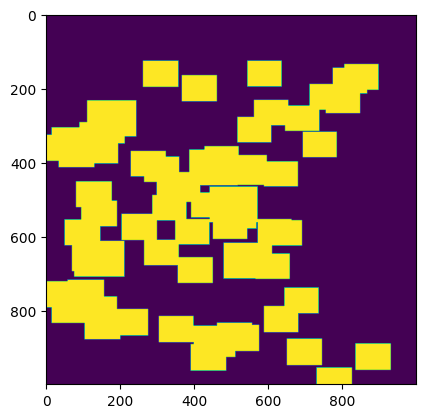

In [20]:
plt.imshow(img)

In [21]:
vs = areas.values()
min(vs), max(vs), sum(vs)/len(vs)

(0.0, 0.744473, 0.4123161822353329)

(array([ 20.,   0.,   3.,  20.,  93., 144., 159., 172., 170., 245., 341.,
        375., 352., 349., 269., 177.,  91.,  45.,  19.,   7.]),
 array([0.        , 0.03722365, 0.0744473 , 0.11167095, 0.1488946 ,
        0.18611825, 0.2233419 , 0.26056555, 0.2977892 , 0.33501285,
        0.3722365 , 0.40946015, 0.4466838 , 0.48390745, 0.5211311 ,
        0.55835475, 0.5955784 , 0.63280205, 0.6700257 , 0.70724935,
        0.744473  ]),
 <BarContainer object of 20 artists>)

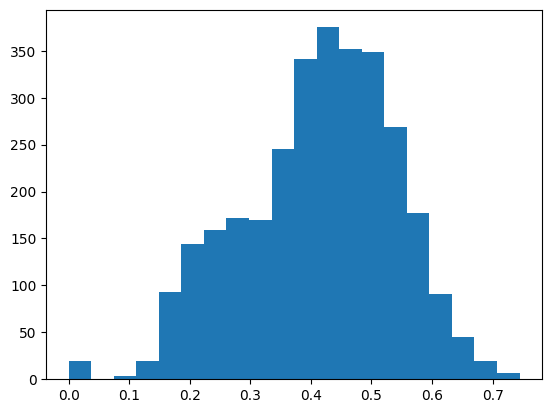

In [22]:
plt.hist(vs, bins=20)